In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PcmPy as pcm
import pickle
import globals as gl
import os
import seaborn as sb
from matplotlib.lines import Line2D
from scipy.stats import ttest_rel
from vis import add_significance_bars

plt.style.use('default')

Base directory found: /cifs/diedrichsen/data/Chord_exp/EFC_learningfMRI
Atlas directory found: /cifs/diedrichsen/data/Atlas_templates/fs_LR_32


In [2]:
sns = [101, 102, 103, 104, 105]
H = 'L'
rois = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']
days = [3, 9, 23]
path = os.path.join(gl.baseDir, gl.pcmDir)

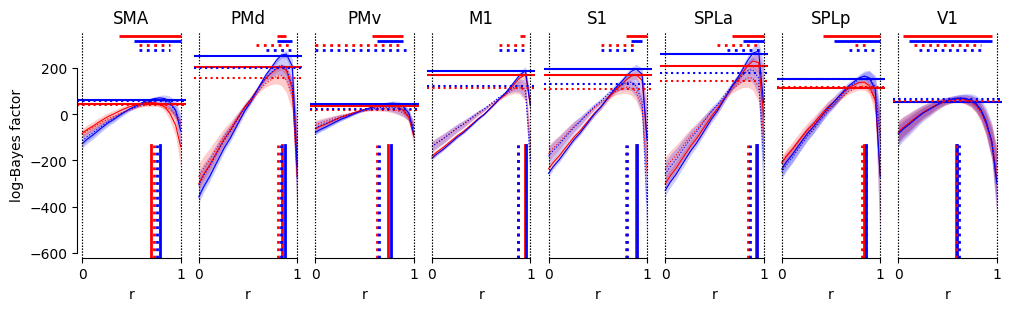

In [9]:
ll = pd.read_csv(os.path.join(path, 'correlation.likelihood.tsv'), sep='\t')
ll = ll.groupby(['chord', 'sn', 'roi', 'r', 'corr', 'Hem']).mean(numeric_only=True).reset_index()
ll = ll[ll['r']!='flex']
ll['r'] = ll['r'].astype(float)

R = pd.read_csv(os.path.join(path, 'correlation.pearsonr.tsv'), sep='\t')
R = R.groupby(['chord', 'sn', 'roi', 'corr', 'Hem']).mean(numeric_only=True).reset_index()

fig, axs = plt.subplots(1, len(rois), sharex=True,  constrained_layout=True, figsize=(10, 3), sharey=True, )

corrs = ll['corr'].unique()
corr = corrs[0]

chord = ll['chord'].unique()
pearsonr = ll['r'].unique()
nsteps = len(pearsonr)
N = len(ll['sn'].unique())

for c, corr in enumerate(corrs):
    for r, roi in enumerate(rois):
        ax = axs[r]
        ll_tmp = ll[(ll['corr'] == corr) & (ll['roi'] == roi) & (ll['Hem'] == H)].reset_index(drop=True)
        sb.lineplot(data=ll_tmp,
                    y='likelihood',
                    x='r',
                    hue='chord',
                    ax=ax,
                    legend=False,
                    lw=.8,
                    ls='-' if c==0 else ':',
                    palette=['red', 'blue'],
                    err_kws={'lw': 0},
                    errorbar='se')
        ax.spines[['left', 'right', 'top']].set_visible(False) if r > 0 else ax.spines[['right', 'top']].set_visible(False)
        ax.spines['left'].set_bounds(ax.get_yticks()[1], ax.get_yticks()[-2])
        ax.spines['bottom'].set_bounds(0, 1)
        ax.tick_params('y', left=False) if r > 0 else None
        ax.axvline(0, color='k', lw=.8, ls=':')
        ax.axvline(1, color='k', lw=.8, ls=':')
        ax.set_title(roi)
        for ch in chord:
            R_tmp = R[(R['corr'] == corr) & (R['roi'] == roi) & (R['Hem'] == H) & (R['chord'] == ch)].reset_index(drop=True)['r'].mean()
            ax.axvline(R_tmp,
                       ymax=.5,
                       color='red' if ch=='trained' else 'blue',
                       lw=2,
                       ls='-' if c==0 else ':',)
            maxL_cv = np.empty(N)
            for n in range(N):
                sn = sns[n]
                ll_tmp_cv = ll_tmp[(ll_tmp['sn'] != sn) & (ll_tmp['chord'] == ch)]
                ll_tmp_cv = ll_tmp_cv.groupby(['r']).mean(numeric_only=True).reset_index(drop=True)
                peak_ind = np.argmax(ll_tmp_cv['likelihood'])
                maxL_cv[n] = ll_tmp[(ll_tmp['sn'] == sn) & (ll_tmp['chord'] == ch)]['likelihood'].to_numpy()[peak_ind]

            pval = np.empty(nsteps)
            for step in range(nsteps):
                ll_tmp_step = ll_tmp[(ll_tmp['r'] == pearsonr[step]) & (ll_tmp['chord'] == ch)]['likelihood'].to_numpy()
                if np.allclose(maxL_cv, ll_tmp_step, equal_nan=True):
                    tval = 0.0
                    pval[step] = 0.5  # For a one-sided test when all differences are 0
                else:
                    tval, pval[step] = ttest_rel(maxL_cv, ll_tmp_step, alternative='greater')
                ax.set_ylabel('log-Bayes factor')

            # ax.axhline(maxL_cv.mean(), color='red' if ch=='trained' else 'blue', linestyle='-' if c==0 else ':')

            add_significance_bars(ax, pearsonr, pval > .05, color='red' if ch=='trained' else 'blue',
                                  position='top', spacing=0, alpha=1, linewidth=2, linestyle='-' if c==0 else ':',)


plt.show()

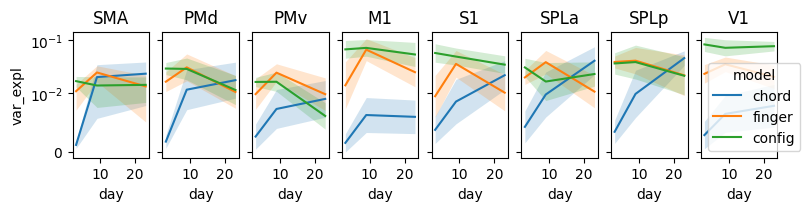

In [8]:
var_expl = pd.DataFrame()
for sn in sns:
    for day in days:
        for roi in rois:
            theta_in = pd.read_pickle(os.path.join(path, f'subj{sn}', f'theta_in.day{day}.{H}.{roi}.p'))[4]
            df = pd.DataFrame()
            df['chord'] = np.exp(theta_in[0])
            df['finger'] = np.exp(theta_in[1])
            df['config'] = np.exp(theta_in[2])
            df['sn'] = sn
            df['day'] = day
            df['roi'] = roi

            var_expl = pd.concat([var_expl, df], ignore_index=True)

var_expl = var_expl.melt(id_vars=['sn', 'day', 'roi'], value_vars=['chord', 'finger', 'config'], value_name='var_expl', var_name='model')

fig, axs = plt.subplots(1, len(rois), sharex=True, sharey=True, constrained_layout=True, figsize=(8, 2))

for r, roi in enumerate(rois):
    ax = axs[r]
    sb.lineplot(data=var_expl[var_expl['roi']==roi],
               x='day',
               y='var_expl',
               ax=ax,
               hue='model',
               errorbar='se',
               legend=False if r<len(rois)-1 else True,
               # showfliers=False,
                err_kws={'lw': 0},
                )
    ax.set_title(roi)
    ax.set_yscale('symlog', linthresh=0.01)



plt.show()

